## Predicting student performance in Dutch schools

This project concerns predictions about students' school performance based on how well they studied in school, so their average school year grade, as well as how good they performed on their school exams. The item we would like to predict is their performance on the final state exam. Additionally, some extrafactors comeinto play, that is the level of their education (according to the Dutch grading system).

So, the question is **How good will a student perform on a state exam based on his overall performance, level of education as well as practice exams?**

The question is quite important to answer for students and their parents. The result of this analysis can be used by these stakeholders, because they will be able to assess their chances at getting into a certain university or getting a scholarship. Additionally, it can be used by schools that would like to improve their reputation because it will identify whatis the main predictor of good State exam results. Thus, schools will be ableto see early which students might fail the final exams and try to help them suceed.

### Table of contents

1.[Data Source](#Data-Source)

2.[Data Quality Check](#Data-Quality-Check)

3.[Data Exploration](#Data-Exploration)

4.[ETL](#Extract-Transform-Load)

5.[Feature Creation](#Feature-Creation)

6.[Non Deep Learning model Definition, Training and Evaluation](#Non-Deep-Learning-model-Definition,-Training-and-Evaluation)

7.[Deep Learning model Definition, Training and Evaluation](#Deep-Learning-model-Definition,-Training-and-Evaluation)

8.[Model Deployment](#Model-Deployment)

9.[Conclusion and Discussion](#Conclusion)

### Data Source

Data is taken from the Dutch government website: https://data.overheid.nl/. The link to the dataset itself can be found here: https://www.duo.nl/open_onderwijsdata/databestanden/vo/leerlingen/leerlingen-vo-7.jsp . The dataset includes data on students who took their final state examination as well as their average grade. More specifically, the following fields were part of the dataset:

| BRIN NUMMER        | VESTIGING NUMMER           | INSTELLINGSNAAM VESTIGING  |GEMENTENAAM VESTIGING | PROVINCIE VESTIGING        | ONDERWIJS TYPE           | AFDELING  |EXAMENCANDIDATEN |GESLAAGDEN        | GEZAKTEN  |GEMIDDELD CIJFER SCHOOLEXAMEN | GEMIDDELD CIJFER CENTRAAL EXAMEN  |GEMIDDELD CIJFER CIJFERLIJST |
| -------------|-------------|-------------|-------------|-------------|-------------|-------------|-------------|-------------|-------------|-------------|-------------|-------------|
| Educational institution code     | Area code | Name of the educational institution | Name of the area| Province name code     | Type of the institution | Department | Numberof exam candidates| N of passed | N of failed | Average grade for the school exam| Average grade at the State exam | Average performance at school|



Obviously, at first the data needs to be downloaded and imported into the notebook:

In [30]:

import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_43d174e2a28c4a688502803b33a6000a = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='tnSn2jOMmTbSLpH6E5EeV0YhQUutl00kR4ths8LtfNIf',
    ibm_auth_endpoint="https://iam.eu-gb.bluemix.net/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.eu-geo.objectstorage.service.networklayer.com')

body = client_43d174e2a28c4a688502803b33a6000a.get_object(Bucket='pythonbasicsfordatascienceproject-donotdelete-pr-tv665solrgtita',Key='07-geslaagden-gezakten-en-cijfers-2017-2018.xlsx')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df = pd.read_excel(body)
df.head()


,BRIN NUMMER,VESTIGINGSNUMMER,INSTELLINGSNAAM VESTIGING,GEMEENTENAAM VESTIGING,PROVINCIE VESTIGING,ONDERWIJSTYPE VO,LEERWEG VMBO,VMBO SECTOR,AFDELING,EXAMENKANDIDATEN,GESLAAGDEN,GEZAKTEN,GEMIDDELD CIJFER SCHOOLEXAMEN,GEMIDDELD CIJFER CENTRAAL EXAMEN,GEMIDDELD CIJFER CIJFERLIJST
0,00AH,00AH00,Opb SGM t Stedelijk Lyceum,ENSCHEDE,Overijssel,HAVO,NaN,NaN,Cultuur en Maatschappij,2,2,0,6.8,6.7,6.9
1,00AH,00AH00,Opb SGM t Stedelijk Lyceum,ENSCHEDE,Overijssel,HAVO,NaN,NaN,Economie en Maatschappij,38,32,6,6.2,6.3,6.4
2,00AH,00AH00,Opb SGM t Stedelijk Lyceum,ENSCHEDE,Overijssel,HAVO,NaN,NaN,Economie en Maatschappij / Cultuur en Maatscha...,5,4,1,6.2,6.0,6.3
3,00AH,00AH00,Opb SGM t Stedelijk Lyceum,ENSCHEDE,Overijssel,HAVO,NaN,NaN,Natuur en Gezondheid,33,23,10,6.2,6.1,6.3
4,00AH,00AH00,Opb SGM t Stedelijk Lyceum,ENSCHEDE,Overijssel,HAVO,NaN,NaN,Natuur en Techniek,4,2,2,6.1,6.1,6.4


### Data Quality Check

#### Missing cases

There are only empty fields in 3 columns out of 14: LEERWEG VMBO, VMBO SECTOR, AFDELING. As we can see, the 2 former ones have a lot of missing values. Out of approximately 10000 entries, almost 6000 are missing. So, these 2 columns contain very little data and are candidates to be removed.

In [3]:
df[['BRIN NUMMER']].count()

BRIN NUMMER    10406
dtype: int64

In [4]:
print('There are empty fields in the following columns: ', df.isnull().any())
print('The number of missing values is: ',df[['LEERWEG VMBO', 'VMBO SECTOR','AFDELING']].isnull().sum() )

There are empty fields in the following columns:  BRIN NUMMER                         False
VESTIGINGSNUMMER                    False
INSTELLINGSNAAM VESTIGING           False
GEMEENTENAAM VESTIGING              False
PROVINCIE VESTIGING                 False
ONDERWIJSTYPE VO                    False
LEERWEG VMBO                         True
VMBO SECTOR                          True
AFDELING                             True
EXAMENKANDIDATEN                    False
GESLAAGDEN                          False
GEZAKTEN                            False
GEMIDDELD CIJFER SCHOOLEXAMEN       False
GEMIDDELD CIJFER CENTRAAL EXAMEN    False
GEMIDDELD CIJFER CIJFERLIJST        False
dtype: bool
The number of missing values is:  LEERWEG VMBO    5751
VMBO SECTOR     6486
AFDELING         735
dtype: int64


#### Data types

Additionally, all the columns data types were identified properly. So, items that must be integer are integer, items that must be float are float, etc. Therefore, no column types needto be changed.

In [67]:
df.dtypes

BRIN NUMMER                          object
VESTIGINGSNUMMER                     object
INSTELLINGSNAAM VESTIGING            object
GEMEENTENAAM VESTIGING               object
PROVINCIE VESTIGING                  object
ONDERWIJSTYPE VO                     object
LEERWEG VMBO                         object
VMBO SECTOR                          object
AFDELING                             object
EXAMENKANDIDATEN                      int64
GESLAAGDEN                            int64
GEZAKTEN                              int64
GEMIDDELD CIJFER SCHOOLEXAMEN       float64
GEMIDDELD CIJFER CENTRAAL EXAMEN    float64
GEMIDDELD CIJFER CIJFERLIJST        float64
dtype: object

#### Duplicate values

Duplicates are not in this dataset. This was mentioned in the data source. Therefore, this check is not needed.

### Data Exploration

The numbers below, showing the main statistics for the data make total sense. The number of candidates can be any. At the same time, the number of people who passed or failed an exam is not higher than the total number of candidates, so this data is of good quality. Data on the grades is also of good quality as it is not lower than 0, but not higher than 10. Therefore, the key statistics show that data used is good.

In [74]:
df.describe()

,EXAMENKANDIDATEN,GESLAAGDEN,GEZAKTEN,GEMIDDELD CIJFER SCHOOLEXAMEN,GEMIDDELD CIJFER CENTRAAL EXAMEN,GEMIDDELD CIJFER CIJFERLIJST
count,10406.000000,10406.000000,10406.000000,10406.000000,10406.000000,10406.000000
mean,19.190563,17.629541,1.561022,6.485047,6.429521,6.591053
std,23.236190,21.497076,2.709315,0.301999,0.402717,0.295508
min,1.000000,0.000000,0.000000,5.100000,3.900000,4.000000
25%,6.000000,5.000000,0.000000,6.300000,6.200000,6.400000
50%,12.000000,11.000000,1.000000,6.500000,6.400000,6.600000
75%,23.000000,21.000000,2.000000,6.700000,6.700000,6.800000
max,242.000000,229.000000,32.000000,9.100000,9.100000,9.000000


#### Feature quality assessment

To do this, a correlation matrix will be created.

In [5]:
import pandas as pd
import numpy as np

corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,EXAMENKANDIDATEN,GESLAAGDEN,GEZAKTEN,GEMIDDELD CIJFER SCHOOLEXAMEN,GEMIDDELD CIJFER CENTRAAL EXAMEN,GEMIDDELD CIJFER CIJFERLIJST
EXAMENKANDIDATEN,1,0.99568,0.67618,-0.0294,-0.047058,-0.0389521
GESLAAGDEN,0.99568,1,0.604851,-0.00638847,-0.0133583,-0.00817554
GEZAKTEN,0.67618,0.604851,1,-0.201457,-0.297597,-0.2692
GEMIDDELD CIJFER SCHOOLEXAMEN,-0.0294,-0.00638847,-0.201457,1,0.571393,0.833844
GEMIDDELD CIJFER CENTRAAL EXAMEN,-0.047058,-0.0133583,-0.297597,0.571393,1,0.784157
GEMIDDELD CIJFER CIJFERLIJST,-0.0389521,-0.00817554,-0.2692,0.833844,0.784157,1


For example, we can see that exam candidates correlates highly with the amount of people who passed. However, this is most likely a spurious correlation. At the same time, we can see that scores of school exams is a good predictor for the governmental exams. So, how good a child performs in school can predict whether he/she will pass or not. However, these numbers do not predict as well those who will fail. Therefore, we can say Dutch schools are good at predicting good students. Furthermore, there is a field that can be removed later, namely: The total amount of candidates. Indeed, it does not provide any additional data and does not help predict whether a certain person will pass in the future or not.

#### Value distributions

We will get histograms of different measures to get an idea of how the different values and measures are distributed. All of the histograms and outputs are presented below.

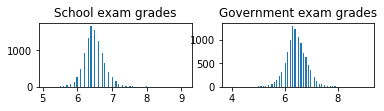

In [56]:
import matplotlib.pyplot as plt

plt.subplot(3, 2, 1)
plt.hist(x=df['GEMIDDELD CIJFER SCHOOLEXAMEN'], bins='auto')
plt.title('School exam grades')

plt.subplot(3, 2, 2)
plt.hist(x=df['GEMIDDELD CIJFER CENTRAAL EXAMEN'], bins='auto')
plt.title('Government exam grades')


plt.show()

Text(0.5, 1.0, 'Student performance')

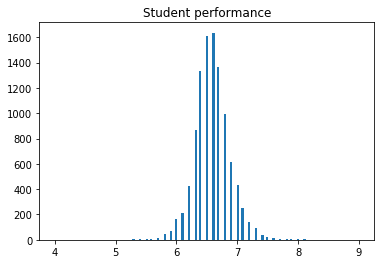

In [57]:
plt.hist(x=df['GEMIDDELD CIJFER CIJFERLIJST'], bins='auto')
plt.title('Student performance')

The distributions are sentered around 5-5.5 which is normal in the Dutch system. Therefore, none of the above variables look alarming or unusual. Thus, the quality of data on exam grades and school grades is high.

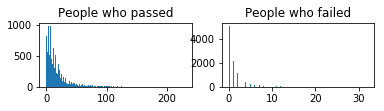

In [58]:
plt.subplot(3, 2, 1)
plt.hist(x=df['GESLAAGDEN'], bins='auto')
plt.title('People who passed')

plt.subplot(3, 2, 2)
plt.hist(x=df['GEZAKTEN'], bins='auto')
plt.title('People who failed')


plt.show()

Text(0.5, 1.0, 'Histogram of Number of exam candidates per school')

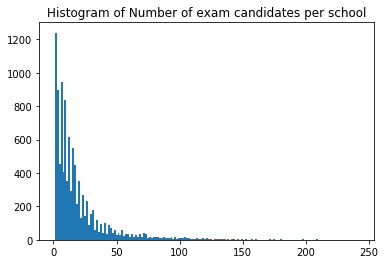

In [34]:
plt.hist(x=df['EXAMENKANDIDATEN'], bins='auto')
plt.title('Histogram of Number of exam candidates per school')

Most of the Dutch schools have around 15-30 people per year, therefore, it is of no surprise that the distribution is so skewed to the right. At the sametime, the amount of people who failed their exam was much lower than those who passed, so the data is not alarming too.

Text(0.5, 1.0, 'Number of Candidates per type of education')

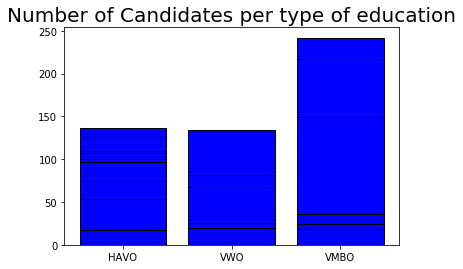

In [41]:
plt.bar(df['ONDERWIJSTYPE VO'],df['EXAMENKANDIDATEN'],color='blue',edgecolor='black')
plt.title('Number of Candidates per type of education',fontsize=20)

There are much more students who study in VMBO because it represents schools of a much higher level of education. Therefore,there is nothing alarming in the fact that there are more people from this typeof education

### Extract Transform Load

ETL takes care of getting data, transforming the data, and storing it to a persistent storage. The data is loaded. We need to transform it, and finally to store it in object store, in this case in the IBM Cloud. However, for this specific Data Science project, ETL is not required. The dataset already comes as one, therefore, no extra processes need to be performed to store it. And the extraction of the data was already performed in an earlier stage for data exploration.

### Feature Creation

#### Data Cleansing

As identified previously the following actions need to be taken to clean the data:

1. Remove LEERWEG VMBO, VMBO SECTOR variables because almost 50% of these fields are missing data;
2. Remove the field EXAMENCANDIDATEN because it does not correlate with any of the fields in meaningful way. 
3. Remove BRIN NUMMER, PROVINCE and VESTEGINGSNUMMER because this data is not meaningful in this context.
4. Remove GESLAAGDEN and GEZAKTEN because this information can be determined from the grades themselves.

In [3]:
df.drop('EXAMENKANDIDATEN', axis=1, inplace=True)
df.drop('LEERWEG VMBO', axis=1, inplace=True)
df.drop('VMBO SECTOR', axis=1, inplace=True)
df.drop('BRIN NUMMER', axis=1, inplace=True)
df.drop('INSTELLINGSNAAM VESTIGING', axis=1, inplace=True)
df.drop('PROVINCIE VESTIGING', axis=1, inplace=True)
df.drop('VESTIGINGSNUMMER', axis=1, inplace=True)
df.drop('GESLAAGDEN', axis=1, inplace=True)
df.drop('GEZAKTEN', axis=1, inplace=True)

If we check, we can see that all the columns have been deleted.

In [4]:
df.columns

Index(['GEMEENTENAAM VESTIGING', 'ONDERWIJSTYPE VO', 'AFDELING',
       'GEMIDDELD CIJFER SCHOOLEXAMEN', 'GEMIDDELD CIJFER CENTRAAL EXAMEN',
       'GEMIDDELD CIJFER CIJFERLIJST'],
      dtype='object')

Therefore, the Data Cleansing part of the project was finished. The data is now of good quality to be processed and validated.

#### Feature Creation

The only task required to be done at this point is one-hot encoding of categorical variables. The rest was either done at the previous step (e.g. dealing with poor quality data and missing fields) or is not required due to how the data is available. No time dimension is available in the dataset, therefore, time manipulations are not needed. Additionally, standartization will be done to ensure that all the variables are on the same scale. Thus, one-hot encoding is the following step:

In [5]:
df = pd.concat([df,pd.get_dummies(df['ONDERWIJSTYPE VO'])],axis=1)
df = pd.concat([df,pd.get_dummies(df['GEMEENTENAAM VESTIGING'])],axis=1)
df = pd.concat([df,pd.get_dummies(df['AFDELING'])],axis=1)
df.drop('ONDERWIJSTYPE VO', axis=1, inplace=True)
df.drop('GEMEENTENAAM VESTIGING', axis=1, inplace=True)
df.drop('AFDELING', axis=1, inplace=True)

In [6]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
df['Gemiddeld cijfer trans'] = sc.fit_transform(df[['GEMIDDELD CIJFER CIJFERLIJST']])
df.drop('GEMIDDELD CIJFER CIJFERLIJST', axis=1, inplace=True)

In [7]:
sc1 = StandardScaler()
df['GEMIDDELD CIJFER SCHOOLEXAMEN trans'] = sc1.fit_transform(df[['GEMIDDELD CIJFER SCHOOLEXAMEN']])
df.drop('GEMIDDELD CIJFER SCHOOLEXAMEN', axis=1, inplace=True)

In [8]:
sc2 = StandardScaler()
df['GEMIDDELD CIJFER CENTRAAL EXAMEN trans'] = sc2.fit_transform(df[['GEMIDDELD CIJFER CENTRAAL EXAMEN']])
df.drop('GEMIDDELD CIJFER CENTRAAL EXAMEN', axis=1, inplace=True)

The following fields have been encoded:  Education type.  This way, we will be able to compare between schools and education levels as well as between geographies: whether schools from particular locations are better than others. Additionally, all the numeric fields, namely 3 types of grades as well as number of people who passed and who did not were standardized to ensure they are on the same scale.

Let's check the database now. Itlooks like it is ready to be used by the model.

In [9]:
df.head(2)

,HAVO,VMBO,VWO,AA EN HUNZE,AALBURG,AALSMEER,AALTEN,ACHTKARSPELEN,ALKMAAR,ALMELO,...,Technologie Orientatie,Transport en Logistiek,Uiterlijke Verzorging,Verzorging,Voertuigentechniek,ZWE,Zorg en Welzijn -ISP,Gemiddeld cijfer trans,GEMIDDELD CIJFER SCHOOLEXAMEN trans,GEMIDDELD CIJFER CENTRAAL EXAMEN trans
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1.045527,1.042943,0.671667
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,-0.646556,-0.943912,-0.321635


### Non Deep Learning model Definition, Training and Evaluation

Since the answer that needs to be found by the algorithm is a grade, which can be a continuou variable from 0 to 10, the algorithm to be used is Regression. At the same time, the evaluation method that will be used is R2. For regression, this evaluation method is the best. 

Firstly, a non Deep Learning environment will be used. The model is defined as follows.

In [87]:
Y = df['GEMIDDELD CIJFER SCHOOLEXAMEN trans']
df.drop('GEMIDDELD CIJFER SCHOOLEXAMEN trans', axis=1,inplace=True)

In [88]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(df,Y)
lr.score(df,Y)

0.768754487886483

As can be seen, the model is doing a good job at predicting the grades: it is currently at 77% accuracy. To try to improve its performance, we will now tryto mormalize the values before passing them, but for this, we will need to change the preprocessing. Namely, we will need to not standardize the grades variable.

In [93]:
Y = df['GEMIDDELD CIJFER SCHOOLEXAMEN']
df.drop('GEMIDDELD CIJFER SCHOOLEXAMEN', axis=1,inplace=True)

In [94]:
lr1 = LinearRegression(normalize=True)
lr1.fit(df,Y)
lr1.score(df,Y)

0.7685211526604193

As can be seen, normalization, actually, decreases model accuracy. It is now a little bit lower than previously. Therefore,it is better to train the model without normalizing its parameters. 

Now, we will try to remove the geographical dimension and split the data into training and testing. The new pre-processing is done in the cell below. It is identical to the first Linear Regression, except it has no geographical dimension.

In [97]:
df.drop('EXAMENKANDIDATEN', axis=1, inplace=True)
df.drop('LEERWEG VMBO', axis=1, inplace=True)
df.drop('VMBO SECTOR', axis=1, inplace=True)
df.drop('BRIN NUMMER', axis=1, inplace=True)
df.drop('INSTELLINGSNAAM VESTIGING', axis=1, inplace=True)
df.drop('PROVINCIE VESTIGING', axis=1, inplace=True)
df.drop('GEMEENTENAAM VESTIGING', axis=1, inplace=True)
df.drop('VESTIGINGSNUMMER', axis=1, inplace=True)
df.drop('GESLAAGDEN', axis=1, inplace=True)
df.drop('GEZAKTEN', axis=1, inplace=True)
df = pd.concat([df,pd.get_dummies(df['ONDERWIJSTYPE VO'])],axis=1)
df = pd.concat([df,pd.get_dummies(df['AFDELING'])],axis=1)
df.drop('ONDERWIJSTYPE VO', axis=1, inplace=True)
df.drop('AFDELING', axis=1, inplace=True)

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
df['Gemiddeld cijfer trans'] = sc.fit_transform(df[['GEMIDDELD CIJFER CIJFERLIJST']])
df.drop('GEMIDDELD CIJFER CIJFERLIJST', axis=1, inplace=True)

sc1 = StandardScaler()
df['GEMIDDELD CIJFER SCHOOLEXAMEN trans'] = sc1.fit_transform(df[['GEMIDDELD CIJFER SCHOOLEXAMEN']])
df.drop('GEMIDDELD CIJFER SCHOOLEXAMEN', axis=1, inplace=True)

sc2 = StandardScaler()
df['GEMIDDELD CIJFER CENTRAAL EXAMEN trans'] = sc2.fit_transform(df[['GEMIDDELD CIJFER CENTRAAL EXAMEN']])
df.drop('GEMIDDELD CIJFER CENTRAAL EXAMEN', axis=1, inplace=True)

In [100]:
Y = df['GEMIDDELD CIJFER SCHOOLEXAMEN trans']
df.drop('GEMIDDELD CIJFER SCHOOLEXAMEN trans', axis=1,inplace=True)

In [101]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(df, Y, test_size=0.33, random_state=42)
lr2 = LinearRegression()
lr2.fit(X_train,Y_train)
lr2.score(X_test,Y_test)

0.7550388338133225

As we can see, accuracy of the model did not change a lot. Therefore, it is obvious that the geography is not adding a lot of value. Therefore, it will be removed in the future model. Now, let's look at the performnce of the model where neither normalization, nor standartization were performed.

In [31]:
df.drop('EXAMENKANDIDATEN', axis=1, inplace=True)
df.drop('LEERWEG VMBO', axis=1, inplace=True)
df.drop('VMBO SECTOR', axis=1, inplace=True)
df.drop('BRIN NUMMER', axis=1, inplace=True)
df.drop('INSTELLINGSNAAM VESTIGING', axis=1, inplace=True)
df.drop('PROVINCIE VESTIGING', axis=1, inplace=True)
df.drop('GEMEENTENAAM VESTIGING', axis=1, inplace=True)
df.drop('VESTIGINGSNUMMER', axis=1, inplace=True)
df.drop('GESLAAGDEN', axis=1, inplace=True)
df.drop('GEZAKTEN', axis=1, inplace=True)
df = pd.concat([df,pd.get_dummies(df['ONDERWIJSTYPE VO'])],axis=1)
df = pd.concat([df,pd.get_dummies(df['AFDELING'])],axis=1)
df.drop('ONDERWIJSTYPE VO', axis=1, inplace=True)
df.drop('AFDELING', axis=1, inplace=True)

Y = df['GEMIDDELD CIJFER SCHOOLEXAMEN']
df.drop('GEMIDDELD CIJFER SCHOOLEXAMEN', axis=1,inplace=True)

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(df, Y, test_size=0.33, random_state=42)
from sklearn.linear_model import LinearRegression
lr3 = LinearRegression()
lr3.fit(X_train,Y_train)
lr3.score(X_test,Y_test)

0.7549771898240034

So, as you can see the model without any parameter tuning has a sligthly lower accuracy.

To conclude, this table provides an overview of accuracy of different linear regressions depending on preprocessing:

|Model|Yes|No|
|-------|------|------|
Geography variable present| 76.85%|75.55%|
Normalized|76.84%|76.85%|
Standardized|76.85%|75.49%|

It is obvious that it is better to use the model with the geographical variable, no normalization but standardized. However, it is not clear what is the causation between geography and grades, therefore, this variable is dropped.

### Deep Learning model Definition, Training and Evaluation

Now, a Deep Learning model will be applied. To not mix up the datasets, we will load it once again and call it *df2*. The geographical dimension will be removed, because it does not add value and there is no strong causation between the grades received and the place where school is situated. Therefore, this dimension will be removed.

#### Definition

In [15]:
import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_43d174e2a28c4a688502803b33a6000a = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='tnSn2jOMmTbSLpH6E5EeV0YhQUutl00kR4ths8LtfNIf',
    ibm_auth_endpoint="https://iam.eu-gb.bluemix.net/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.eu-geo.objectstorage.service.networklayer.com')

body = client_43d174e2a28c4a688502803b33a6000a.get_object(Bucket='pythonbasicsfordatascienceproject-donotdelete-pr-tv665solrgtita',Key='07-geslaagden-gezakten-en-cijfers-2017-2018.xlsx')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df2 = pd.read_excel(body)

df2.drop('EXAMENKANDIDATEN', axis=1, inplace=True)
df2.drop('LEERWEG VMBO', axis=1, inplace=True)
df2.drop('VMBO SECTOR', axis=1, inplace=True)
df2.drop('BRIN NUMMER', axis=1, inplace=True)
df2.drop('INSTELLINGSNAAM VESTIGING', axis=1, inplace=True)
df2.drop('PROVINCIE VESTIGING', axis=1, inplace=True)
df2.drop('VESTIGINGSNUMMER', axis=1, inplace=True)
df2.drop('GESLAAGDEN', axis=1, inplace=True)
df2.drop('GEZAKTEN', axis=1, inplace=True)
df2 = pd.concat([df2,pd.get_dummies(df2['ONDERWIJSTYPE VO'])],axis=1)
df2 = pd.concat([df2,pd.get_dummies(df2['AFDELING'])],axis=1)
df2.drop('ONDERWIJSTYPE VO', axis=1, inplace=True)
df2.drop('GEMEENTENAAM VESTIGING', axis=1, inplace=True)
df2.drop('AFDELING', axis=1, inplace=True)

Keras learning environment was chosen as it is easy to implement in Python and provides a lot of opportunities. 

In [11]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD

Using TensorFlow backend.


We will need to check the dimensionality of the dataset to build the model later. Additionally, the data will be split into train and test datasets to be able to evaluate the data later.

In [16]:
dataset = df2.values
X = dataset[:,0:53].astype(float) # number of cols-1
Y = dataset[:,53]

In [17]:
import numpy as np
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

In [18]:
X_train.shape

(6972, 53)

The model is then built and compiled. We add 2 dense layers. 2 models will be created and their performance will be checked. They will use the same dataset, but different activation functions, different optimizaers and different loss will be used. THis way we will be able to see which model performs better.

In [75]:
import numpy
seed = 7
numpy.random.seed(seed)
# create model
model = Sequential()
model.add(Dense(53, input_dim=53, activation='sigmoid'))
model.add(Dense(1, activation='softmax'))
model.compile(loss='mean_squared_error', optimizer='sgd', metrics=['accuracy'])

In [22]:
import numpy
seed = 7
numpy.random.seed(seed)
# create model
model1 = Sequential()
model1.add(Dense(53, input_dim=53, activation='relu'))
model1.add(Dense(1, activation='softmax'))
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

#### Training

In [76]:
model.fit(X_train, Y_train, batch_size=83, nb_epoch=20, verbose=1)

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  if __name__ == '__main__':


Epoch 1/20
6972/6972 [==============================] - 1s 125us/step - loss: 0.9891 - acc: 0.0109
Epoch 2/20
6972/6972 [==============================] - 0s 60us/step - loss: 0.9891 - acc: 0.0109
Epoch 3/20
6972/6972 [==============================] - 0s 69us/step - loss: 0.9891 - acc: 0.0109
Epoch 4/20
6972/6972 [==============================] - 0s 62us/step - loss: 0.9891 - acc: 0.0109
Epoch 5/20
6972/6972 [==============================] - 0s 63us/step - loss: 0.9891 - acc: 0.0109
Epoch 6/20
6972/6972 [==============================] - 0s 61us/step - loss: 0.9891 - acc: 0.0109
Epoch 7/20
6972/6972 [==============================] - 0s 68us/step - loss: 0.9891 - acc: 0.0109
Epoch 8/20
6972/6972 [==============================] - 0s 61us/step - loss: 0.9891 - acc: 0.0109
Epoch 9/20
6972/6972 [==============================] - 0s 64us/step - loss: 0.9891 - acc: 0.0109
Epoch 10/20
6972/6972 [==============================] - 0s 59us/step - loss: 0.9891 - acc: 0.0109
Epoch 11/20
6972/6

In [23]:
model1.fit(X_train, Y_train, batch_size=83, nb_epoch=20, verbose=1)

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  if __name__ == '__main__':


Epoch 1/20
6972/6972 [==============================] - 10s 1ms/step - loss: 15.7686 - acc: 0.0109
Epoch 2/20
6972/6972 [==============================] - 23s 3ms/step - loss: 15.7686 - acc: 0.0109
Epoch 3/20
6972/6972 [==============================] - 68s 10ms/step - loss: 15.7686 - acc: 0.0109
Epoch 4/20
6972/6972 [==============================] - 72s 10ms/step - loss: 15.7686 - acc: 0.0109
Epoch 5/20
6972/6972 [==============================] - 78s 11ms/step - loss: 15.7686 - acc: 0.0109
Epoch 6/20
6972/6972 [==============================] - 78s 11ms/step - loss: 15.7686 - acc: 0.0109
Epoch 7/20
6972/6972 [==============================] - 85s 12ms/step - loss: 15.7686 - acc: 0.0109
Epoch 8/20
6972/6972 [==============================] - 87s 12ms/step - loss: 15.7686 - acc: 0.0109
Epoch 9/20
6972/6972 [==============================] - 82s 12ms/step - loss: 15.7686 - acc: 0.0109
Epoch 10/20
6972/6972 [==============================] - 83s 12ms/step - loss: 15.7686 - acc: 0.0109
E

#### Evaluation

In [79]:
model.evaluate(X_test,Y_test)

3434/3434 [==============================] - 0s 136us/step


[0.9886429819452534, 0.011357018054746652]

In [24]:
model1.evaluate(X_test,Y_test)

3434/3434 [==============================] - 55s 16ms/step


[15.761325839514225, 0.011357018054746652]

As can be seen, the deep learning model is performing rather poorly. Indeed, there is a lot of room for improvement, however, this is not required as the Linear Regression model already gives pretty good accuracy and results for the real world, therefore, it can be used to predict grades.

### Model Deployment

The model and the ADD product will be available on GitHub at this link. There it will be possible to download the notebook and use the model for predicting the performance of students in the future.

[GitHub Repository](https://github.com/ganastas/Predicting-grades-of-students-in-Dutch-schools)

### Conclusion

As a result of this project, a Linear Regression model was created that can predict the performance of students on the future exam with 76% accuracy was created. It was determined that normalizing the values has a negative effect on the model performance. Additionally, standartization has a positive effect on the model performance. Furthermore, dropping the geography OneHotEncoding decreases model performance, however it is a spurious correlation, therefore, it is needed.

The Linear Regression Model was made available through GitHub in the public repository. 

A Deep Learning model was also created. However, this models' performance was very low. It only improved slightly when different activation function was used and different loss was applied. Loss changed as a result of this. However, the model still stayed low quality because its accuracy is just 1%.

#### Discussion

During this project, a model that can predict student performance was created. The features that were included are:

* Average student grade
* Average school exam grade
* Level of education
* Department

The results of the project can be used by the following **stakeholders**:

1. *Students* - they can assess their chances to enter certain universities, get scholarships. If needed, students can take timely action to get better grade on the final exam.

2. *Parents* - they can understand where their children need extra support and coaching and provide it in a timely manner to ensure good results for the final exam.

3. *Schools* - they can identify problematic students early and take action to ensure that students pass exams with good grades to improve repuration and education quality.